# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [65]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform


all_data = pd.read_excel("alldata.xlsx")
dr_data = pd.read_excel("drdata.xlsx")
dr_questions = pd.read_excel("drq.xlsx")
elected_data = pd.read_excel("electeddata.xlsx")
tv2_data = pd.read_excel("tv2data.xlsx")
tv2_questions = pd.read_excel("tv2q.xlsx")

#getting an overview of how data looks and column names
# print("All data:\n", all_data.head())
# print("DR data:\n", dr_data.head())
# print("DR questions:\n", dr_questions.head())
# print("Elected data:\n", elected_data.head())
# print("TV2 data:\n", tv2_data.head())
# print("TV2 questions:\n", tv2_questions.head())


# Differences in responses between candidates, inter-party & intra-party, explain which parties have the most internal disagreements.

#dropping columns which do not contain responses
response_columns = all_data.columns.drop(['navn', 'parti', 'storkreds', 'alder'])
#check - print(response_columns)

#grouping columns by the party and calculating variance 
intraparty_variation = all_data.groupby('parti')[response_columns].var()

#summing the variance across all questions -> shows the overall measure of disagreement for each party
intraparty_variation['total_variance'] = intraparty_variation.sum(axis=1) # axis=1 tells pandas to sum across columns for each row, in this case - sums the variance of responses for each question within the same party.

#sort by total variance to see which parties have the most internal disagreements
intraparty_variation_sorted = intraparty_variation[['total_variance']].sort_values(by='total_variance', ascending=False)

print("Intraparty:\n", intraparty_variation_sorted)




Intraparty:
                                              total_variance
parti                                                      
Løsgænger                                        129.000000
Kristendemokraterne                               54.930314
Alternativet                                      44.522388
Dansk Folkeparti                                  42.531463
Det Konservative Folkeparti                       42.482117
Moderaterne                                       41.904762
Radikale Venstre                                  39.376300
Venstre                                           36.756598
Socialdemokratiet                                 35.805667
Frie Grønne, Danmarks Nye Venstrefløjsparti       31.863077
Liberal Alliance                                  31.610559
Enhedslisten                                      28.037023
Socialistisk Folkeparti                           24.345135
Danmarksdemokraterne                              20.447447
Nye Borgerlige             

By analyzing internal disagreements, we can see that Løsgænger has the highest total variance in member responses, which indicates substantial disagreements on key issues. Due to the high total variance, it can be inferred that the members have very diverse opinions, which might make coming to agreements in political decisions challenging. 


Interparty:
                                              average_response
parti                                                        
Moderaterne                                          0.315841
Socialistisk Folkeparti                              0.252770
Socialdemokratiet                                    0.247947
Alternativet                                         0.215656
Kristendemokraterne                                  0.181730
Radikale Venstre                                     0.175754
Dansk Folkeparti                                     0.131195
Enhedslisten                                         0.095422
Frie Grønne, Danmarks Nye Venstrefløjsparti          0.091837
Løsgænger                                           -0.013605
Venstre                                             -0.028912
Det Konservative Folkeparti                         -0.056851
Danmarksdemokraterne                                -0.113072
Nye Borgerlige                                      -0.1

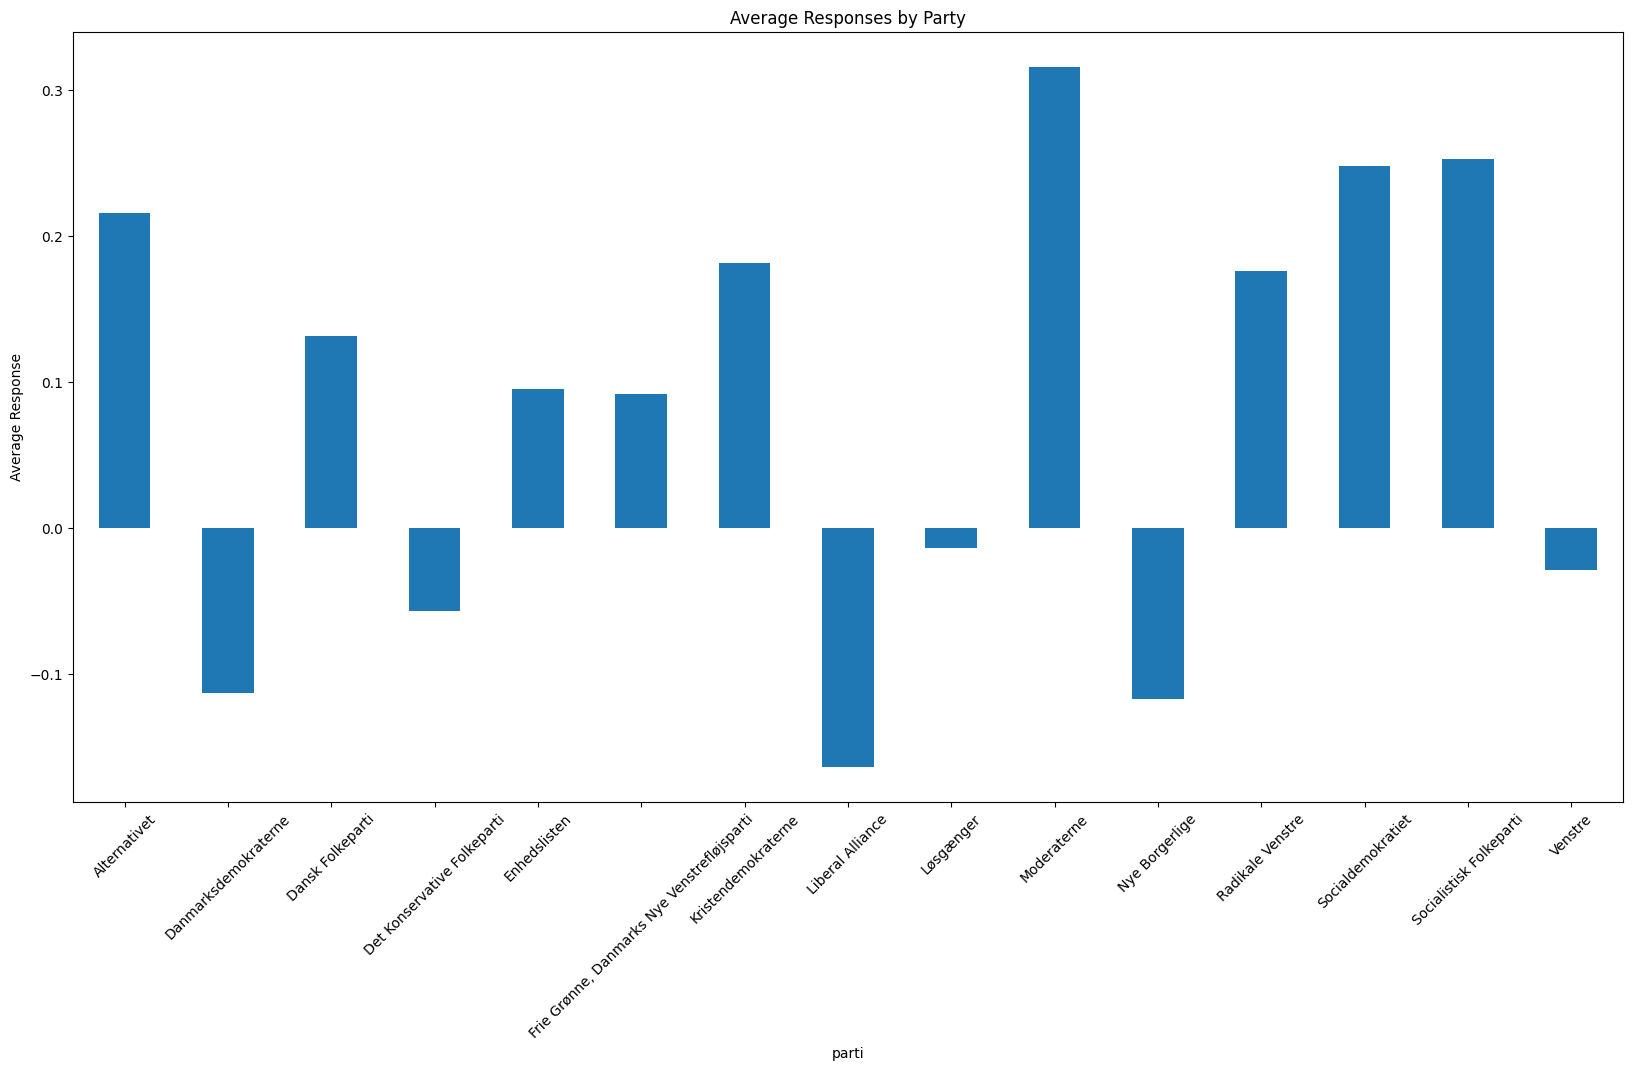

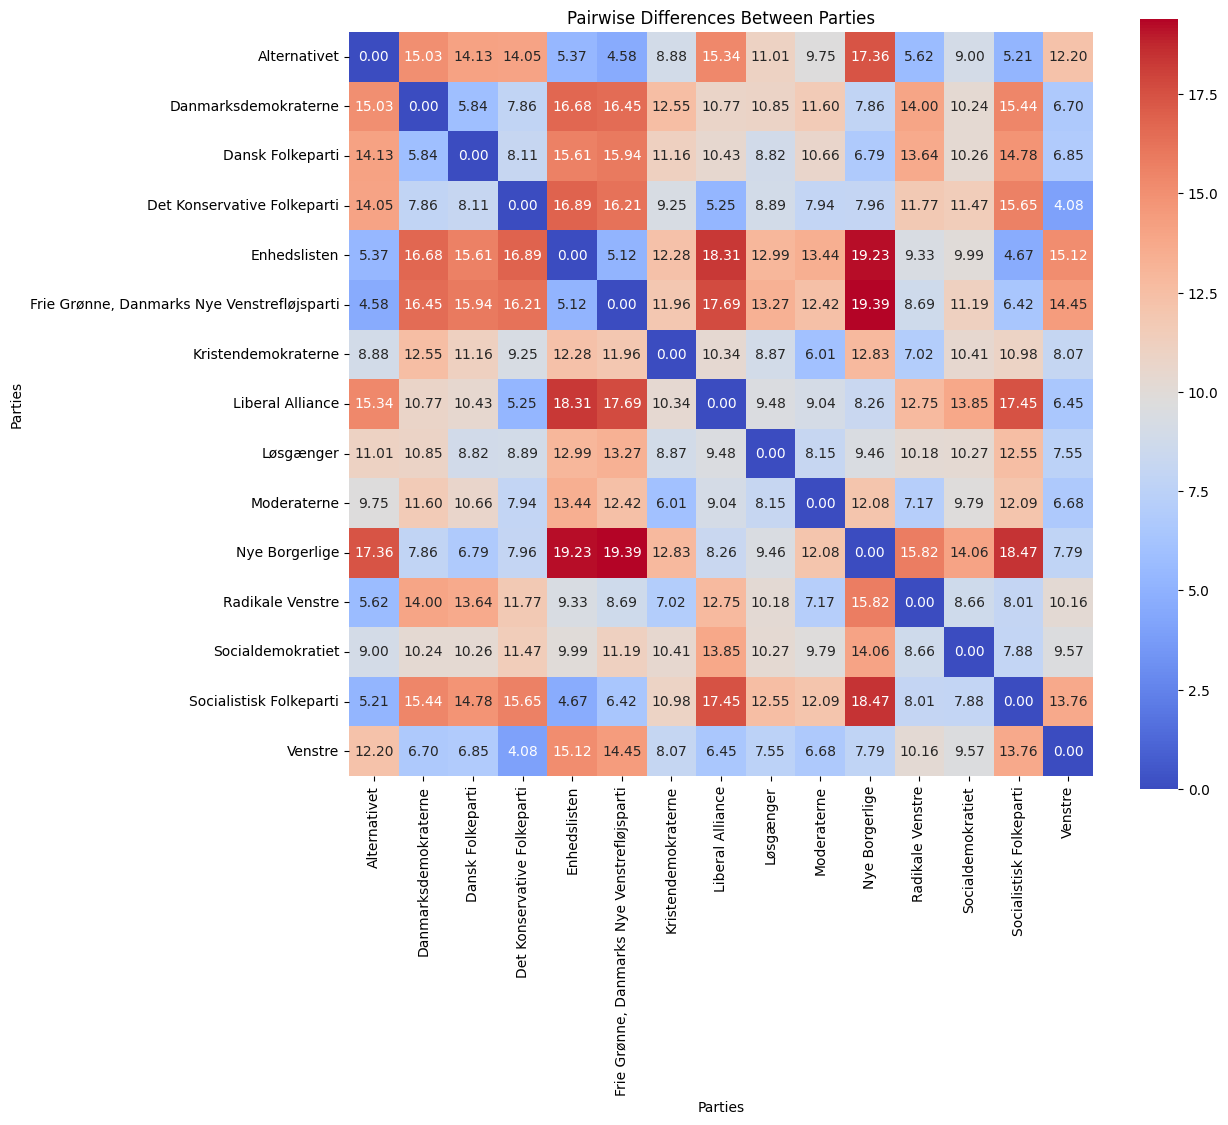

In [68]:
#doing the same for intraparty differences

interparty_means = all_data.groupby('parti')[response_columns].mean()

#get the overall average response across all questions for each party
interparty_means['average_response'] = interparty_means.mean(axis=1)

#sort parties by their overall average response
interparty_means_sorted = interparty_means[['average_response']].sort_values(by='average_response', ascending=False)

#display the sorted interparty differences
print("\nInterparty:\n", interparty_means_sorted)


interparty_means['average_response'].plot(kind='bar', figsize=(20, 10))
plt.title('Average Responses by Party')
plt.ylabel('Average Response')
plt.xticks(rotation=45)
plt.show()

distance_matrix = pdist(interparty_means, metric='euclidean')
distance_df = squareform(distance_matrix)

# Convert to DataFrame for better readability
distance_df = pd.DataFrame(distance_df, index=interparty_means.index, columns=interparty_means.index)

# Sort the distance matrix for easier interpretation
sorted_distance_df = distance_df.sort_index(axis=1).sort_index(axis=0)

# Visualize the distance matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_distance_df, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pairwise Differences Between Parties')
plt.xlabel('Parties')
plt.ylabel('Parties')
plt.show()




Number of rows where age is 0: 18
                                  mean  min  max
parti                                           
Alternativet                 48.416667   21   79
Danmarksdemokraterne         51.216216   24   69
Dansk Folkeparti             46.048387   20   75
Det Konservative Folkeparti  44.600000   20   66
Enhedslisten                 42.466667   19   79
Frie Grønne                  33.612903   20   62
Kristendemokraterne          51.877551   21   74
Liberal Alliance             38.392405   18   72
Løsgænger                    50.500000   40   58
Moderaterne                  44.812500   19   78
Nye Borgerlige               48.730769   20   70
Radikale Venstre             45.521127   21   78
Socialdemokratiet            45.627907   20   78
Socialistisk Folkeparti      42.350649   20   68
Venstre                      47.260870   18   72


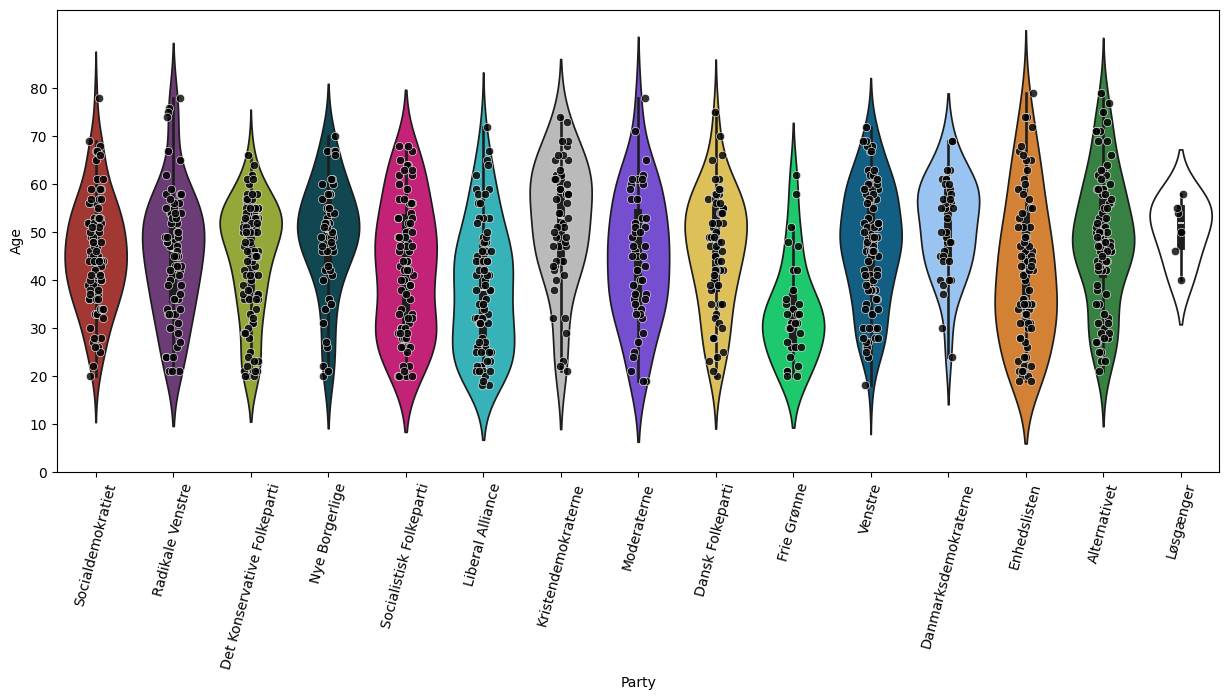

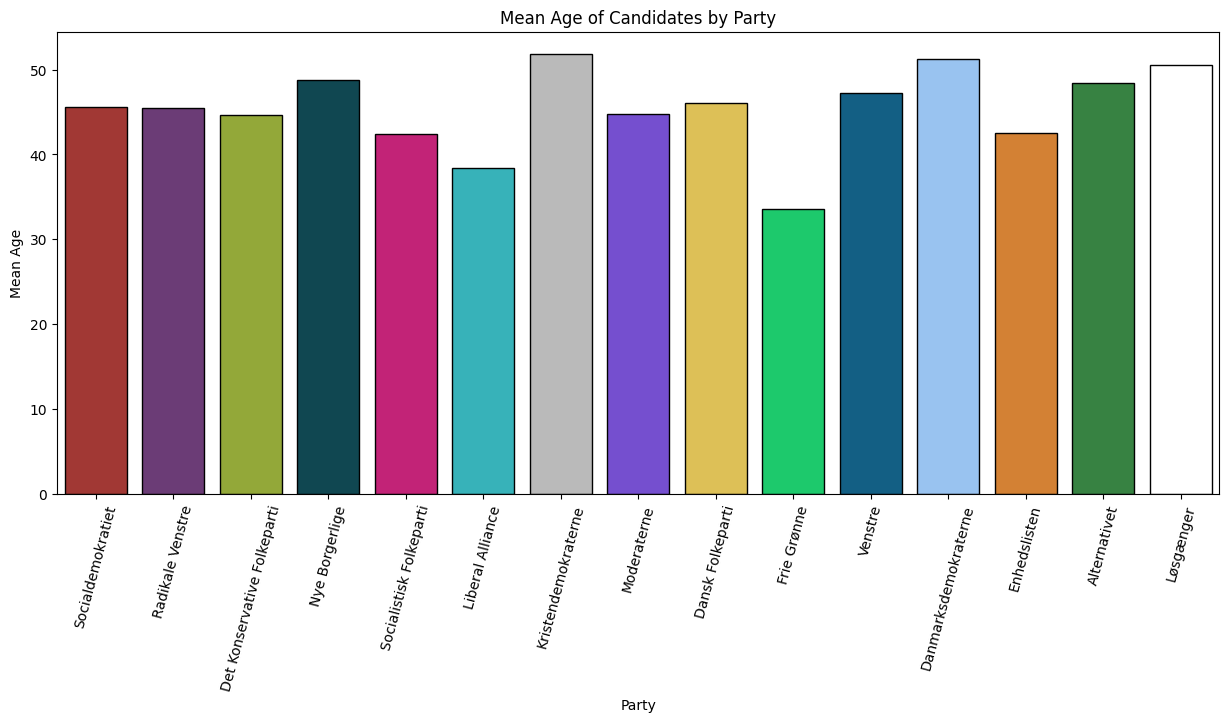

In [70]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

data5= pd.read_excel('tv2data.xlsx')
danskcolor = {"Socialdemokratiet": '#b32722',
"Radikale Venstre" : '#713280',
"Det Konservative Folkeparti": '#9eba27',
"Nye Borgerlige": '#054f5c',
"Socialistisk Folkeparti" : '#dd0878',
"Liberal Alliance": '#21c6cf',
"Kristendemokraterne": '#bababa',
"Moderaterne": '#6c39e5',
"Dansk Folkeparti": '#f3cd41',
"Frie Grønne": '#00e66a',
"Venstre": '#006697',
"Danmarksdemokraterne": '#8ac3ff',
"Enhedslisten": '#ed8019',
"Alternativet": '#2a8f39',
"Løsgænger": '#ffffff'}
ordered_parties = list(danskcolor.keys())

data_politician_age = data5[['parti', 'alder']]
data_politician_age.loc[:, 'parti'] = data_politician_age['parti'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')

count_deleted_rows = data_politician_age[data_politician_age['alder'] == 0].shape[0]
print(f"Number of rows where age is 0: {count_deleted_rows}")
data_politician_age = data_politician_age[data_politician_age['alder'] != 0]


grouped_data_politician_age = data_politician_age.groupby('parti')['alder'].agg(['mean', 'min', 'max'])
print(grouped_data_politician_age)


plt.figure(figsize=(15, 6))
sns.violinplot(x='parti', y='alder', hue='parti', data=data_politician_age, palette=danskcolor, legend=False, order=ordered_parties)
sns.stripplot(x='parti', y='alder', data=data_politician_age, color='black', alpha=0.8, size=6, jitter=True, edgecolor='white', linewidth=0.5)
plt.xlabel('Party')
plt.yticks(range(0, data_politician_age['alder'].max() + 10, 10))
plt.xticks(rotation=75)
plt.ylabel('Age')
plt.show()


plt.figure(figsize=(15, 6))
sns.barplot(x=grouped_data_politician_age.index, y=grouped_data_politician_age['mean'], hue=grouped_data_politician_age.index, palette=danskcolor, edgecolor='black',order=ordered_parties)
plt.title('Mean Age of Candidates by Party')
plt.xlabel('Party')
plt.ylabel('Mean Age')
plt.xticks(rotation=75)
plt.show()